# Advanced spectral fitting tutorial
by Xiaoyuan Zhang @ MPE


In this notebook, we will discuss:
- Cofitting of source & background spectra;
- Spectral fitting with a Bayesian approach (Python package [BXA](https://johannesbuchner.github.io/BXA/index.html), based on the nested sampling algorithm).

<div class="alert alert-block alert-info"> 
Further information: 
    <ul> On Wednesday, Gabriele Ponti et al. will cover Milkyway foreground emission. </ul>
    <ul> On Thursday, Johannes Buchner will introduce more about BXA. </ul>
    
Stay tuned!
</div>

## Components in a cluster spectrum

A cluster spectrum usually includes:
1. Cluster emission (absorbed apec)
2. Intrument particle background (modeled with filter-wheel-closed data)
3. Cosmic X-ray background (absorbed power law)
4. Milkyway halo emission (absorbed apec)
5. Local hot bubble (unabsorbed apec)
6. Other possible Milkyway components...

A background spectrum includes all foreground / background components (2-). The idea of source & background spectra cofitting is to simultaneously model the source and foreground / background components.


- Astronomical foreground / background components are photons going through the mirrors and the observed spectrum is folded by the ARF. 
- Particle backgrounds are modeled without an ARF.

In [1]:
import os
import shutil
import xspec as xs
import matplotlib.pyplot as plt
from astropy.io import fits  # load it after xspec, otherwise there could be problems from the CFITSIO library
import bxa.xspec as bxa
import ultranest.plot as upl

xs.Xset.chatter = 1  # to reduce a significant amount of xspec console output
xs.Fit.statMethod = "cstat"  # fitting statistics = Cash-statistics
xs.Xset.cosmo = "70 0 0.7"  # H0=70, q0=0, O_lambda=0.7
xs.Xset.abund = "aspl"  # Reference abundance table Asplund+09




Becasue of the definition of ARF normalization and EXPOSURE of the Srctool outputs, cofitting the source and background spectra needs additional settings. 

There are many ways to achieve that. In this notebook, I will introduce my personal preference:
1. Modify EXPOSURE and ARF normalizations;
2. Define multiple *sources* in Xspec to account for components of different origins.



### File modification

We aim to change the definitions of 
1. EXPOSURE -> the averaged exposure time across the spectral extraction region.
2. ARF -> the total effective area with vignetting (and PSF) correction.

with the ratio $r\equiv t_\mathrm{srctool}/t_\mathrm{ave}=\Omega_\mathrm{regarea}/\Omega_\mathrm{backscal}$

We will have 
- $t_\mathrm{src,corr}=t_\mathrm{src,srctool}/r_\mathrm{src}$
- $A(E)_\mathrm{src,corr}=A(E)_\mathrm{src,srctool} \times r_\mathrm{src}$
- $A(E)_\mathrm{bkg,corr}=A(E)_\mathrm{bkg,srctool} \times r_\mathrm{bkg}$

Becasue we aim to use the same models to fit both the spectra, the EXPOSURE of the background spectrum needs an additional correction for the ratio between the two extraction regions. 
- $t_\mathrm{bkg,corr}=t_\mathrm{bkg,srctool}/r_\mathrm{bkg}/(\Omega_\mathrm{regarea,bkg}/\Omega_\mathrm{regarea,src})$

In [2]:
# obtain parameter values

exposure_src = fits.getval("analysis/output_spectra/src_500kpc820_SourceSpec_00001.fits", 
                           "exposure", ext=1)
exposure_bkg = fits.getval("analysis/output_spectra/bkg_1p5-2deg820_SourceSpec_00001.fits", 
                           "exposure", ext=1)
backscal_src = fits.getval("analysis/output_spectra/src_500kpc820_SourceSpec_00001.fits", 
                           "backscal", ext=1)
backscal_bkg = fits.getval("analysis/output_spectra/bkg_1p5-2deg820_SourceSpec_00001.fits", 
                           "backscal", ext=1)
regarea_src = fits.getval("analysis/output_spectra/src_500kpc820_SourceSpec_00001.fits", 
                          "regarea", ext=1)
regarea_bkg = fits.getval("analysis/output_spectra/bkg_1p5-2deg820_SourceSpec_00001.fits", 
                          "regarea", ext=1)
arfmax_src = fits.getdata("analysis/output_spectra/src_500kpc820_ARF_00001.fits", 
                          ext=1)["SPECRESP"].max()
arfmax_bkg = fits.getdata("analysis/output_spectra/bkg_1p5-2deg820_ARF_00001.fits", 
                          ext=1)["SPECRESP"].max()

r_src = regarea_src / backscal_src
r_bkg = regarea_bkg / backscal_bkg


# copy files and modify values
shutil.copy("analysis/output_spectra/src_500kpc820_SourceSpec_00001.grp",
            "analysis/output_spectra/src_500kpc820_SourceSpec_00001_corr.grp")
fits.setval("analysis/output_spectra/src_500kpc820_SourceSpec_00001_corr.grp",
            "exposure", value=exposure_src / r_src, ext=1)
shutil.copy("analysis/output_spectra/bkg_1p5-2deg820_SourceSpec_00001.grp",
            "analysis/output_spectra/bkg_1p5-2deg820_SourceSpec_00001_corr.grp")
fits.setval("analysis/output_spectra/bkg_1p5-2deg820_SourceSpec_00001_corr.grp",
            "exposure", value=exposure_bkg / r_bkg * (regarea_bkg / regarea_src) , ext=1)

shutil.copy("analysis/output_spectra/src_500kpc820_ARF_00001.fits",
            "analysis/output_spectra/src_500kpc820_ARF_00001_corr.fits",)
with fits.open("analysis/output_spectra/src_500kpc820_ARF_00001_corr.fits") as hdu:
    hdu[1].data["SPECRESP"] *= r_src
    hdu.writeto("analysis/output_spectra/src_500kpc820_ARF_00001_corr.fits", overwrite=True)
shutil.copy("analysis/output_spectra/bkg_1p5-2deg820_ARF_00001.fits",
            "analysis/output_spectra/bkg_1p5-2deg820_ARF_00001_corr.fits",)
with fits.open("analysis/output_spectra/bkg_1p5-2deg820_ARF_00001_corr.fits") as hdu:
    hdu[1].data["SPECRESP"] *= r_bkg
    hdu.writeto("analysis/output_spectra/bkg_1p5-2deg820_ARF_00001_corr.fits", overwrite=True)

### Load spectra and define different sources

Here we load the source and background spectra separately and define three sources using the `multiresponse` attribute.

The three sources are:
- src1: cluster emission
- src2: astrophysical foreground / background components
- src3: particle background (w/o folding the ARF)

And the two spectra includes:
- source spectrum: src1 + src2 + src3
- background spectrum: src2 + src3

In [3]:
xs.AllData.clear()
pwd = os.getcwd()
os.chdir("analysis/output_spectra/")


spec_src = xs.Spectrum("src_500kpc820_SourceSpec_00001_corr.grp")
spec_src.multiresponse[0].arf = "src_500kpc820_ARF_00001_corr.fits"
spec_src.multiresponse[1] = "src_500kpc820_RMF_00001.fits"
spec_src.multiresponse[1].arf = "src_500kpc820_ARF_00001_corr.fits"
spec_src.multiresponse[2] = "src_500kpc820_RMF_00001.fits"  # RMF only for src3


spec_bkg = xs.Spectrum("bkg_1p5-2deg820_SourceSpec_00001_corr.grp")
spec_bkg.multiresponse[1] = "bkg_1p5-2deg820_RMF_00001.fits"
spec_bkg.multiresponse[1].arf = "bkg_1p5-2deg820_ARF_00001_corr.fits"
spec_bkg.multiresponse[2] = "bkg_1p5-2deg820_RMF_00001.fits"  # RMF only for src3
spec_bkg.multiresponse[0] = None  # remove src1 from the background spectrum

os.chdir(pwd)  # switch the current dirctory back


xs.AllData.ignore("**-0.3,7.0-**")

In [4]:
xs.Xset.chatter = 10
xs.AllData.show()
xs.Xset.chatter = 1


2 files 2 spectra 
Spectrum 1  Spectral Data File: src_500kpc820_SourceSpec_00001_corr.grp
Net count rate (cts/s) for Spectrum:1  3.880e+01 +/- 4.501e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  6-97
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 191.5 sec
 Using fit statistic: cstat
 Using Response (RMF) File            src_500kpc820_RMF_00001.fits for Source 1
 Using Auxiliary Response (ARF) File  src_500kpc820_ARF_00001_corr.fits
 Using Response (RMF) File            src_500kpc820_RMF_00001.fits for Source 2
 Using Auxiliary Response (ARF) File  src_500kpc820_ARF_00001_corr.fits
 Using Response (RMF) File            src_500kpc820_RMF_00001.fits for Source 3

Spectrum 2  Spectral Data File: bkg_1p5-2deg820_SourceSpec_00001_corr.grp
Net count rate (cts/s) for Spectrum:2  1.095e+01 +/- 9.690e-02
 Assigned to Data Group 1 and Plot Group 2
  Noticed Channels:  6-107
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Ti

### Define models

We will define:
- model for src1: cluster emission **[tbabs * apec]**
- model for src2: astrophysical foregournd / background components **[tbabs * (powerlaw + apec) + apec]**
- model for src3: particle background (FWC background)

The Xspec model of the TM-8 FWC for DR1 can be found at https://erosita.mpe.mpg.de/dr1/AllSkySurveyData_dr1/FWC_dr1/.

In this notebook, I customized the model file, where I added a constant factor for the normalization and assign the model to source-3. The customized file is `TM8_FWC_c010_mod_customized.dat`.

In [5]:
xs.AllModels.clear()

m_src = xs.Model("tbabs*apec", "src", 1)  # define model for src1 and name it "src"
m_bkg = xs.Model("tbabs*(powerlaw+apec)+apec", "bkg", 2)  # define model for src2 and name it "bkg"
xs.Xset.restore("TM8_FWC_c010_mod_customized.dat")  # load fwc model from the file
m_fwc = xs.AllModels(1, "fwc")  # point the "fwc" model from data group 1 to the variable m_fwc

# to set all parameters of fwc frozon, except the constant.
for _name in m_fwc.componentNames:
    if _name != "constant":
        _comp = m_fwc.__getattribute__(_name)
        for _pname in _comp.parameterNames:
            _par = _comp.__getattribute__(_pname)
            _par.frozen = True
        



***Warning: The file sent to Xset.restore(): TM8_FWC_c010_mod_customized.dat
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.




tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.


In [6]:
xs.Xset.chatter = 10
xs.AllModels.show()
xs.Xset.chatter = 2


Parameters defined:
Model bkg:TBabs<1>(powerlaw<2> + apec<3>) + apec<4> Source No.: 2   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   3    2   powerlaw   norm                1.00000      +/-  0.0          
   4    3   apec       kT         keV      1.00000      +/-  0.0          
   5    3   apec       Abundanc            1.00000      frozen
   6    3   apec       Redshift            0.0          frozen
   7    3   apec       norm                1.00000      +/-  0.0          
   8    4   apec       kT         keV      1.00000      +/-  0.0          
   9    4   apec       Abundanc            1.00000      frozen
  10    4   apec       Redshift            0.0          frozen
  11    4   apec       norm                1.00000      +/-  0.0          
________________________________________________________________

### setting parameters

- Milkyway halo has a tempreature about 0.2 keV and metallicity less than 0.1 solar ([Ponti et al. 2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...674A.195P/abstract))
- Local hot bubble has a temperature about 0.1 keV
- Cosmic X-ray background has a photon index of 1.41 ([de Luca & Molendi 2004](https://ui.adsabs.harvard.edu/abs/2004A%26A...419..837D/abstract))

In [7]:
m_src.TBabs.nH = 6e-2
m_src.TBabs.nH.frozen = True

m_src.apec.kT = 3
m_src.apec.kT.frozen = False
m_src.apec.Abundanc = 0.4
m_src.apec.Redshift = 0.0129

m_bkg.TBabs.nH.link = m_src.TBabs.nH
m_bkg.powerlaw.PhoIndex = 1.41
m_bkg.powerlaw.PhoIndex.frozen = True
m_bkg.apec.kT = 0.2
m_bkg.apec.kT.frozen = True
m_bkg.apec.Abundanc = 0.1
m_bkg.apec_4.kT = 0.1
m_bkg.apec_4.kT.frozen = True
m_bkg.apec_4.Abundanc = 1


### Fit

In [8]:
xs.Fit.renorm()
xs.Fit.perform()
xs.Fit.perform()

m_bkg.apec.kT.frozen = False
m_bkg.apec.Abundanc.frozen = False
xs.Fit.perform()

Fitting results

In [9]:
xs.Xset.chatter=10
xs.AllModels.show()
xs.Xset.chatter = 1


Parameters defined:
Model bkg:TBabs<1>(powerlaw<2> + apec<3>) + apec<4> Source No.: 2   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    6.00000E-02  = src:p1
   2    2   powerlaw   PhoIndex            1.41000      frozen
   3    2   powerlaw   norm                2.37747E-03  +/-  9.30583E-05  
   4    3   apec       kT         keV      0.201833     +/-  7.07361E-03  
   5    3   apec       Abundanc            9.08560E-02  +/-  2.57847E-02  
   6    3   apec       Redshift            0.0          frozen
   7    3   apec       norm                3.62619E-02  +/-  9.27332E-03  
   8    4   apec       kT         keV      0.100000     frozen
   9    4   apec       Abundanc            1.00000      frozen
  10    4   apec       Redshift            0.0          frozen
  11    4   apec       norm                5.59417E-03  +/-  1.08093E-03  
________________________________________________________________________

Model fwc:co

### Plot the best-fit models

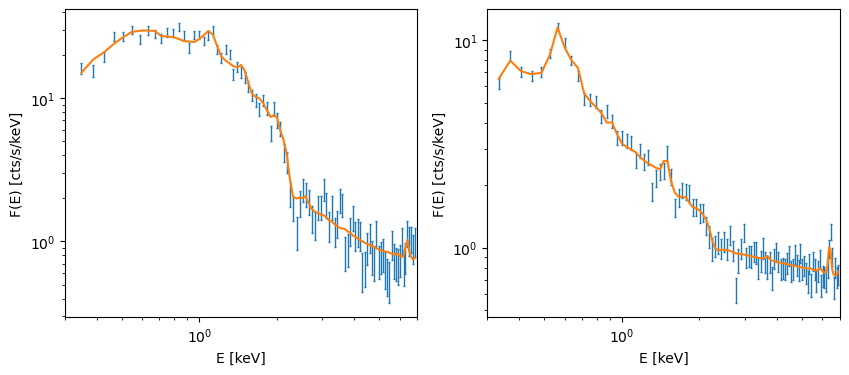

In [10]:


plt.figure(figsize=(10,4))
xs.Plot.xAxis = "keV"
xs.Plot.background = False
xs.Plot("data")

for plot_grp in [1, 2]:
    plt.subplot(int(f"12{plot_grp}"))
    x = xs.Plot.x(plot_grp)
    y = xs.Plot.y(plot_grp)
    yerr = xs.Plot.yErr(plot_grp)
    ymo = xs.Plot.model(plot_grp)


    plt.errorbar(x, y, yerr=yerr, ls="", capsize=1, elinewidth=1)
    plt.loglog(x, ymo)

    plt.xlim(0.3,7)
    plt.xlabel("E [keV]")
    plt.ylabel("F(E) [cts/s/keV]")
plt.show()

In [11]:
xs.Xset.chatter = 10
xs.Fit.show()
xs.Xset.chatter = 1


Fit statistic  : C-Statistic                  120.01     using 92 bins, spectrum 1.
                 C-Statistic                   89.05     using 102 bins, spectrum 2.
Total fit statistic                           209.06     with 186 d.o.f.

Test statistic : Chi-Squared                  215.71     using 194 bins.
 Null hypothesis probability of 6.69e-02 with 186 degrees of freedom


## Beysian inference with BXA

We will define priors
- `loguniform` for m_src.apec.norm, m_bkg.powerlaw.norm, m_bkg.apec.norm, m_bkg.apec_4.norm
- `gaussian` for m_src.apec.kT, m_bkg.apec.kT, m_bkg.apec.Abundanc, m_fwc.constant.factor

In [12]:
# setting ranges for normalization parameters
m_src.apec.norm.values = [.1, 1e-3, 1e-3, 1e-3, 1e0, 1e0]
m_bkg.powerlaw.norm.values = [1e-3, 1e-3, 1e-5, 1e-5, 1e0, 1e0]
m_bkg.apec.norm.values = [1e-2, 1e-3, 1e-5, 1e-5, 1e0, 1e0]
m_bkg.apec_4.norm.values = [1e-3, 1e-3, 1e-5, 1e-5, 1e0, 1e0]


transformations = [
    bxa.create_loguniform_prior_for(m_src, m_src.apec.norm),
    bxa.create_gaussian_prior_for(m_src, m_src.apec.kT, 3, 2),
    bxa.create_gaussian_prior_for(m_src, m_src.apec.Abundanc, 0.4, 0.1),
    bxa.create_loguniform_prior_for(m_bkg, m_bkg.powerlaw.norm),
    bxa.create_gaussian_prior_for(m_bkg, m_bkg.apec.kT, 0.2, 0.1),
    bxa.create_gaussian_prior_for(m_bkg, m_bkg.apec.Abundanc, 0.1, 0.03),
    bxa.create_loguniform_prior_for(m_bkg, m_bkg.apec.norm),
    bxa.create_loguniform_prior_for(m_bkg, m_bkg.apec_4.norm),
    bxa.create_gaussian_prior_for(m_bkg, m_bkg.apec_4.kT, 0.1, 0.03),
    bxa.create_gaussian_prior_for(m_fwc, m_fwc.constant.factor, 1, 0.1),
    
]

  jeffreys prior for norm between 1.000000e-03 and 1.000000e+00 
  gaussian prior for kT of 3.000000 +- 2.000000
  gaussian prior for Abundanc of 0.400000 +- 0.100000
  jeffreys prior for norm between 1.000000e-05 and 1.000000e+00 
  gaussian prior for kT of 0.200000 +- 0.100000
  gaussian prior for Abundanc of 0.100000 +- 0.030000
  jeffreys prior for norm between 1.000000e-05 and 1.000000e+00 
  jeffreys prior for norm between 1.000000e-05 and 1.000000e+00 
  gaussian prior for kT of 0.100000 +- 0.030000
  gaussian prior for factor of 1.000000 +- 0.100000


Run!

In [13]:
shutil.rmtree("temp_results")
outputfiles_basename = "temp_results"
solver = bxa.BXASolver(transformations=transformations, outputfiles_basename=outputfiles_basename)
results = solver.run(resume=True, speed="auto")


[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  56 [-968.6977..-775.1664] | it/evals=2399/40126 eff=6.0389% N=400       0 0 
[ultranest] Likelihood function evaluations: 40126
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Reached maximum number of likelihood calls (40126 > 40000)...
[ultranest] done iterating.
[ultranest] Widening roots to 400 live points (have 400 already) ...


[ultranest] Explored until L=-1e+02  .40 [-104.2566..-104.2560]*| it/evals=12748/2018477 eff=0.5231% N=400 
[ultranest] Likelihood function evaluations: 2018477
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -131.3 +- 0.1424
[ultranest] Effective samples strategy satisfied (ESS = 3155.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.24 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = -131.314 +- 0.322
  single instance: logZ = -131.314 +- 0.242
  bootstrapped   : logZ = -131.280 +- 0.322
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations
step sampler diagnostic: jump distance 0.96 (should be >1), far enough fraction: 49.55% : very fishy. Double nst

### Corner plot of the posteriors

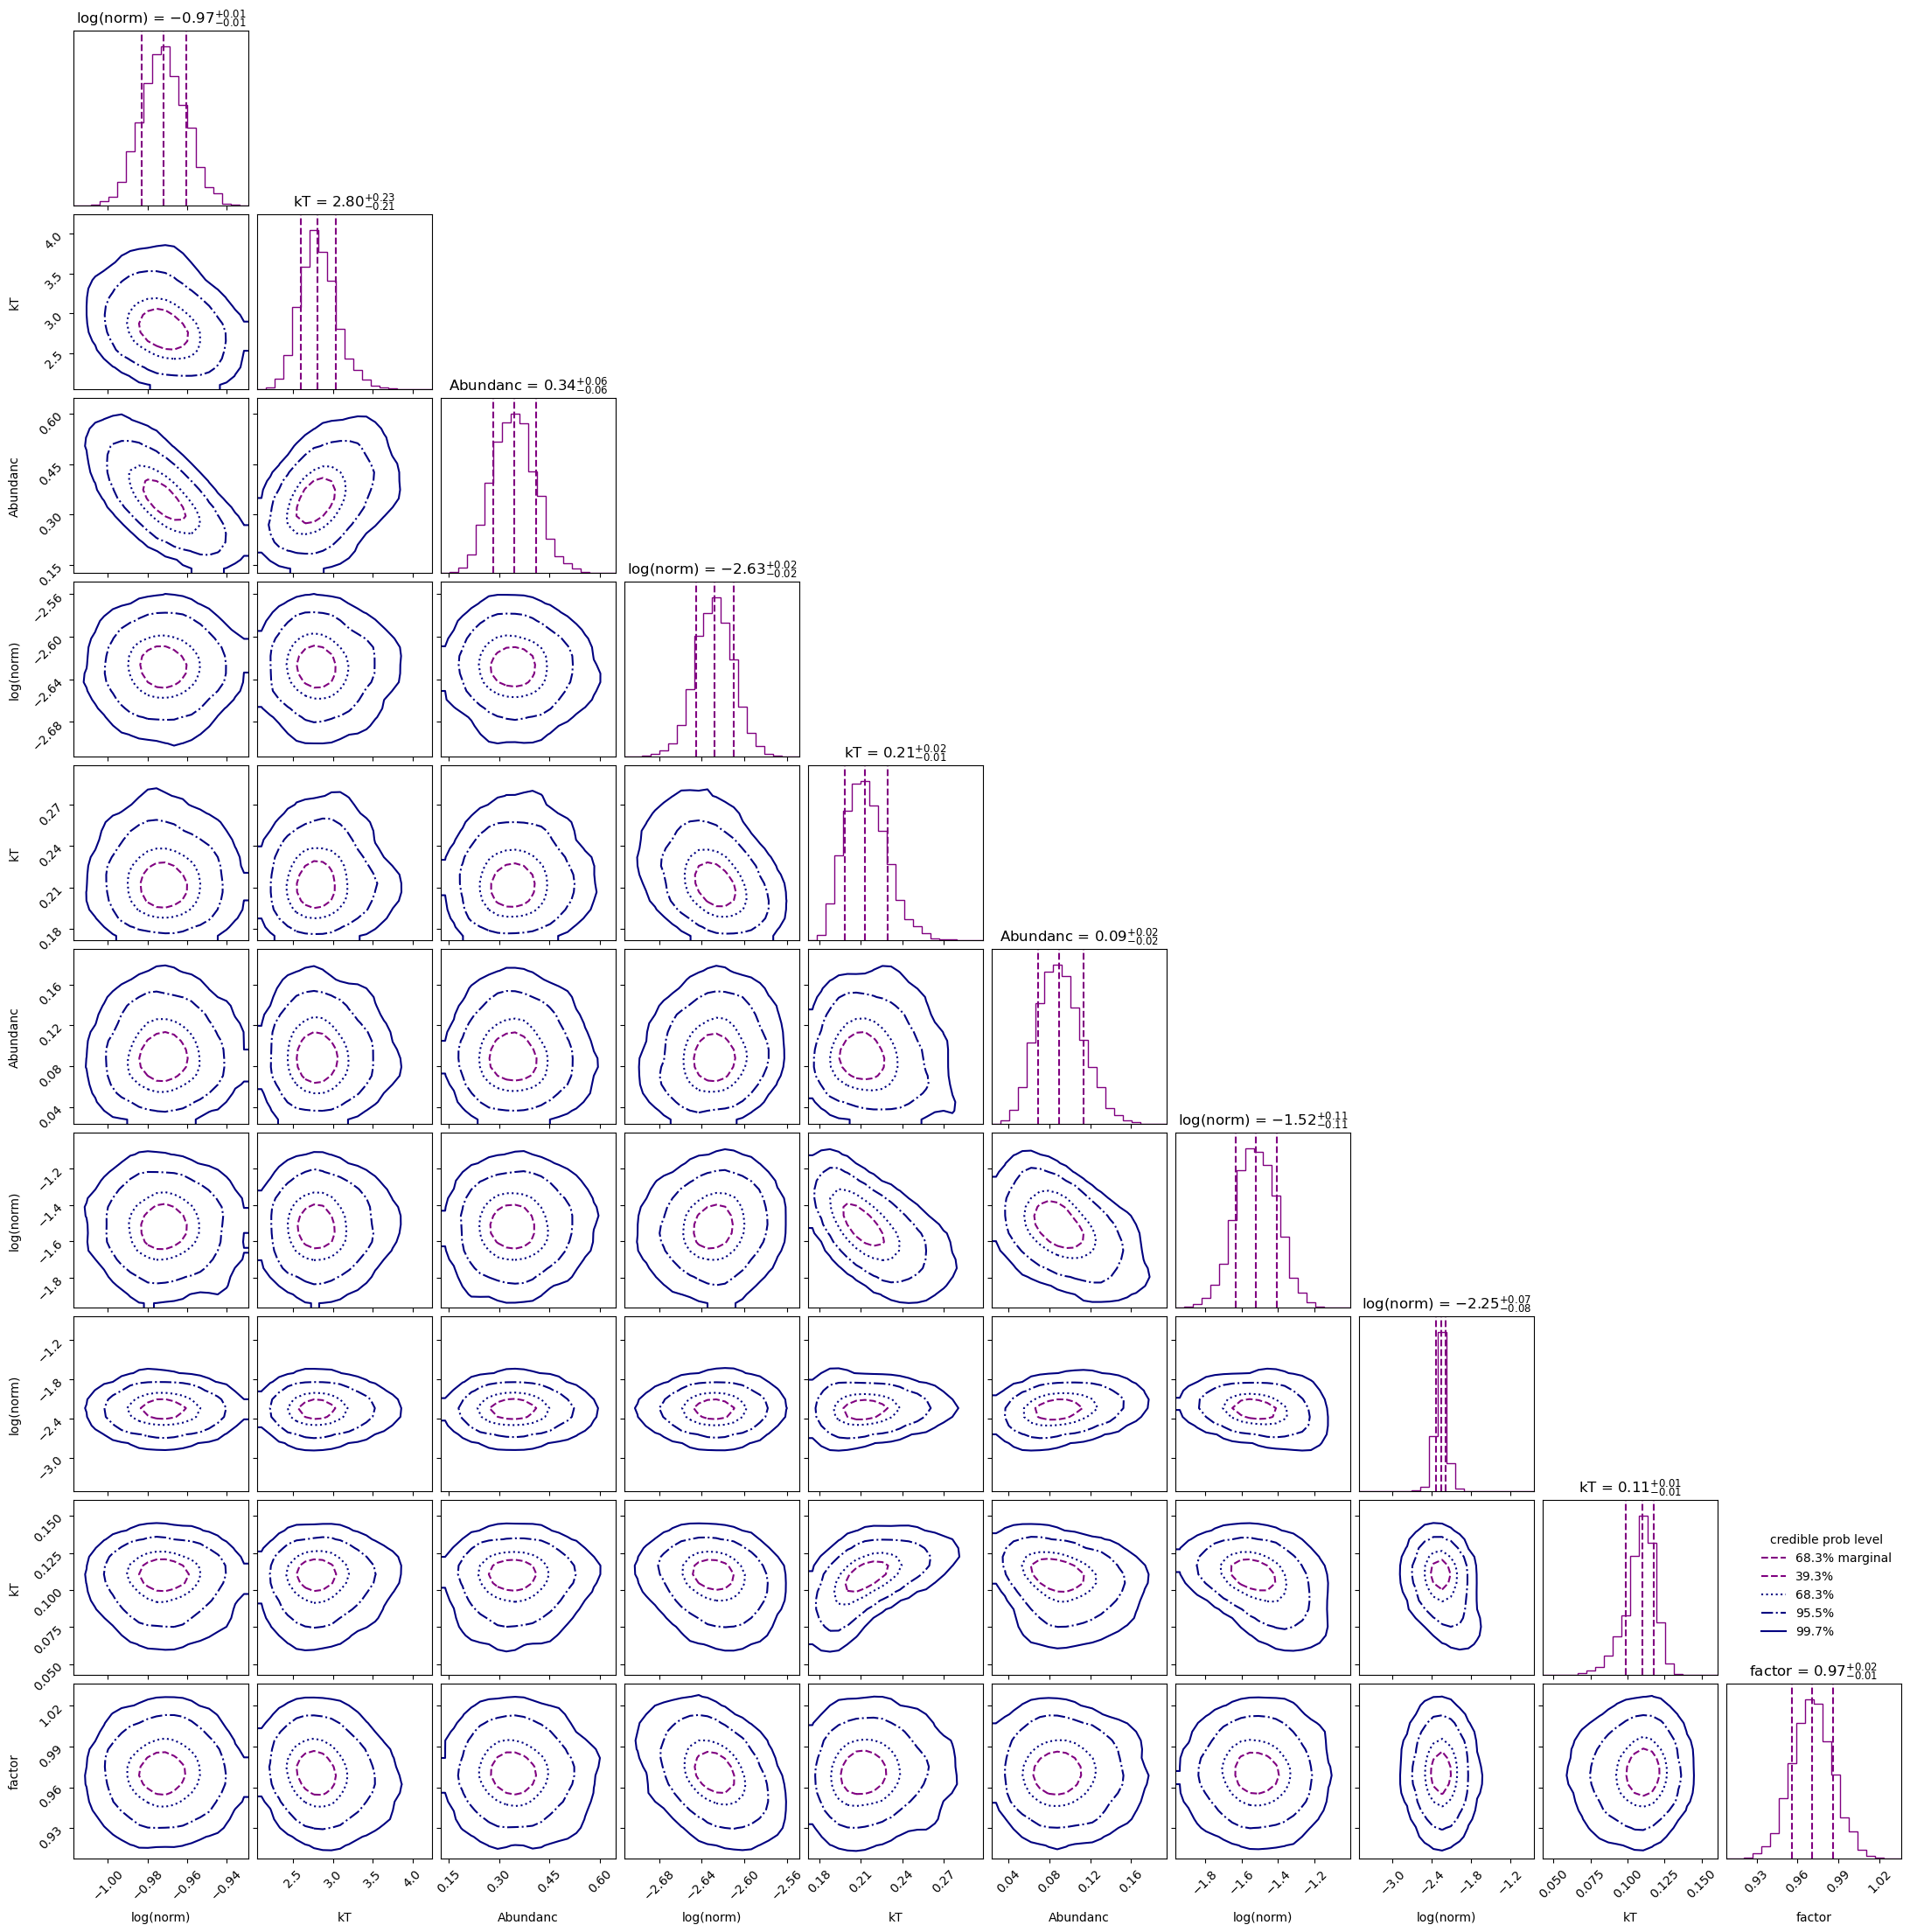

In [14]:
upl.cornerplot(results, smooth=1)
plt.show()